In [28]:
import paramiko
import getpass

host = "158.251.88.197"
port = 22
username = "iaraya"
password = getpass.getpass()

ssh = paramiko.SSHClient()
ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
ssh.connect(host, port, username, password)

### Loading the instance

In [29]:
from bsg import load_LargeInstance
from mclp import generate_candidate_solution
import numpy as np

#L,W,H,boxes,id2box = load_BRinstance(filename="BR8.txt",inst=4, nbox=1)
#L,W,H,boxes,id2box = load_BRKGAinstance(filename="../benchs/class7/200.txt",inst=1, nbox=1)

i = 15
file_name = "../benchs/Data_Large/L_2500/L_2500_{}.txt".format(i)
r_param = 1.5
min_fr = 0.99
max_bl = 10000 #
bsg_time = 5 #Tiempo de BSG
swap_iteration = 1000 #Numero de Swaps
n = 2 #Cantidad de cajas a escoger para hacer swap

L,W,H,boxes,id2box = load_LargeInstance(filename=file_name, nbox=1, rot_allowed=True)
_boxes=boxes.copy()

extra_args = f'--max_bl={max_bl} --min_fr={min_fr}'
Vmax = L*W*H

### Estimating adjusted vols (optional)

In [30]:
from sklearn.linear_model import LinearRegression

boxes=_boxes.copy()
nsols = 10
bins = []
extra_args_regr = '--greedy_only'
bsg_time = 1

for _ in range(nsols):
    bin  = generate_candidate_solution(ssh,L,W,H,boxes,id2box, r_param=r_param, bsg_time=bsg_time, extra_args=extra_args_regr)
    bins = [*bins,*bin[:-5]]
    boxes=_boxes.copy()
    
#10x1 + 5x2 +7x3 = 1
#7x3 + 1x7 = 1
#7x3 + 14x1 = 1 
#...

X = []; y=[]
for bin in bins:
    x = np.zeros(len(_boxes))
    i=0
    for box in _boxes:
        if box in bin.boxes:
            x[i]=bin.boxes[box]
        i+=1
    X.append(x)
    y.append(1.0)

reg = LinearRegression(fit_intercept=False).fit(X, y)

i = 0

for box in _boxes:
    vol = box.vol/(L*W*H) 
    if reg.coef_[i] < vol: 
        box.adj_vol=vol
    else: 
        box.adj_vol=reg.coef_[i]
    i+=1
    
#print( reg.coef_)

Initial Solution: 19
Initial Solution: 19
Initial Solution: 19
Initial Solution: 19
Initial Solution: 19
Initial Solution: 19
Initial Solution: 19
Initial Solution: 19
Initial Solution: 19
Initial Solution: 19


In [31]:
import copy as cp

i=0
precomputed_vols = reg.coef_
vols = cp.deepcopy(reg.coef_)
for box in _boxes:
    vol = box.vol/(L*W*H) 
    vols[i] = vol
    if precomputed_vols[i] < vol: 
        precomputed_vols[i]=vol
    box.adj_vol=precomputed_vols[i]
    i+=1

(0.0024468087384274468, 0.012853556456035052)

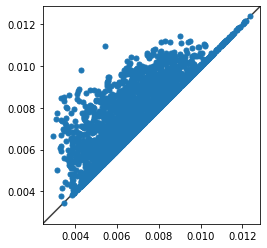

In [32]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.scatter(vols, precomputed_vols, s=25,cmap=plt.cm.coolwarm, zorder=10)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

### Solver

In [33]:
from mclp import get_random_bin

def get_adjusted_vol(boxes):
    vol=0.0
    for box in boxes:
        vol += box.adj_vol*boxes[box]
    return vol

def get_vol(boxes):
    vol=0.0
    for box in boxes:
        vol += box.vol*boxes[box]
    return vol
      
def adjusted_swap(solution, n=2,  max_vol_accept=1.0, tolerance=0.1, verbose=True):

    iter_record = {
        'var_init': -1,
        'var_final': -1,
        'vols': [],
        'adj_vols': []
    }

    bin_A = get_random_bin(s = solution)
    bin_B = get_random_bin(s = solution, b = bin_A)
    
    iniA = bin_A.adj_vol
    iniB = bin_B.adj_vol

    iter_record['vols'] = [bin_A.vol, bin_B.vol]/Vmax
    iter_record['adj_vols'] = [iniA, iniB]

    var_ini = (bin_A.adj_vol-1.0)**2 + (bin_B.adj_vol-1.0)**2
    iter_record['var_init'] = var_ini

    nA = int(random.randint(1, n))
    boxes_A = bin_A.pop_random_boxes(nA)
    adjvolA = get_adjusted_vol(boxes_A)
    
    nB = int(random.randint(0, n))
    boxes_B = bin_B.pop_random_boxes(nB)
    adjvolB = get_adjusted_vol(boxes_B)
    
    r = tolerance*random.random()
    accepted = False
    
    if adjvolA > adjvolB and bin_B.adj_vol + adjvolA <= max_vol_accept + r:
        accepted = True
    elif adjvolB > adjvolA and  bin_A.adj_vol + adjvolB <= max_vol_accept + r:
        accepted = True
    
    if accepted:
        bin_A.insert_boxes(boxes_B)
        bin_B.insert_boxes(boxes_A)
    else: 
        iter_record['var_final'] = -10
        return -10, iter_record
        
    var_final = (bin_A.adj_vol-1.0)**2 + (bin_B.adj_vol-1.0)**2
        
    var_diff = var_final - var_ini
    #if var_diff>0:
    #    print(iniA, bin_A.adj_vol)
    #    print(iniB, bin_B.adj_vol)
    iter_record['var_final'] = var_final
    
    return var_diff, iter_record

def get_sorted_vols(solution):
    volumens = []
    for s in solution:
        s_boxes = s.boxes
        vol_boxes = get_vol(s_boxes)/(10**6)
        volumens.append(vol_boxes)

    volumens.sort()
    return volumens

def get_sorted_bins(solution):
    solution = cp.deepcopy(solution)
    list_solution = list(solution)
    list_solution.sort(key=lambda x: x.vol)
    return list_solution

In [34]:
import time as time

boxes=_boxes.copy()

initial_generation = time.time()
init_solution=generate_candidate_solution(ssh,L,W,H,boxes,id2box, r_param=r_param, bsg_time=bsg_time ,extra_args=extra_args)

complete_generation = time.time()
generation_time= complete_generation-initial_generation

boxes_to_plot = get_sorted_bins(init_solution)[0].boxes
vol_bin = get_vol(boxes_to_plot)/(10**6)


print("Less Volumen: {}".format(vol_bin))
print("Generation time: {}".format(generation_time))

Initial Solution: 19
Less Volumen: 33.35983
Generation time: 27.45499873161316


In [35]:
import copy as cp
for bin in init_solution:
    bin.set_adj_vol(get_adjusted_vol(bin.boxes))
    bin.set_vol(get_vol(bin.boxes))

# Bins adjusted volumes
print("adjusted volumes of each bin:",[get_adjusted_vol(bin.boxes) for bin in init_solution])
print([get_vol(bin.boxes)/(L*W*H) for bin in init_solution])
best_solution = cp.deepcopy(init_solution)

operations_ = {}

adjusted volumes of each bin: [1.0322801394240246, 1.038231225856383, 1.0212870564277619, 1.0244991459490898, 1.032567505209076, 1.014060785853747, 1.0421174712725874, 1.0500103683931077, 1.0371667877310748, 1.0379805717056856, 1.0584854526936422, 1.054947237003377, 1.0221060750733129, 1.0591726554901877, 1.0523279636538114, 1.0679504824375181, 1.0505467223550216, 1.0763816754288673, 0.19775833471876444]
[0.9276710185949211, 0.9347229115136657, 0.9256965375197983, 0.9222852713594768, 0.9247927210601109, 0.924562192524919, 0.9350623084704832, 0.9276806401719025, 0.931780711135204, 0.931999254411208, 0.9301913990276256, 0.9255339718000477, 0.9245878871409042, 0.9345773921138274, 0.9228826155650809, 0.9375405041278094, 0.9124971243025156, 0.9151049887848841, 0.1736578685687579]


In [36]:
### ALGORITMO GENERAL
from base.Heuristics.mclp import verify_solution

swap_record = {}

initial_time = time.time()

for i in range(swap_iteration):
    solution = cp.deepcopy(best_solution)
    
    diff_var, i_record = adjusted_swap(solution, n=n,  max_vol_accept=1.1, tolerance=0.3, verbose=True)

    swap_record[str(i)] = i_record

    if diff_var>0:
        verified_solution=True
        #max_bl: maxima cantidad de bloques a generar por bsg
        #min_fr: minimo porcentaje ocupado para considerar la generación de un bloque
        if not verify_solution(ssh, solution, id2box, bsg_time=1, args="--max_bl=10000 --min_fr=0.99", verbose=False):
            #print(i,"verification fails", [(b.adj_vol,b.vol) for b in solution if b.verify==False])
            verified_solution=False

        if verified_solution:
            minAdj = 1.0
            minB = None
            for bin in solution:
                if bin.adj_vol < minAdj:
                    minAdj=bin.adj_vol
                    minB=bin
            print(diff_var)
            print(bin.id, ":", bin, bin.utilization, bin.adj_vol, bin.verify)
            best_solution = cp.deepcopy(solution)

final_time = time.time()
resolution_time = final_time - initial_time


NameError: name 'Vmax' is not defined

In [ ]:
print([get_vol(bin.boxes)/(L*W*H) for bin in best_solution])

print(f"Solution: {len(best_solution)}")

boxes_to_plot = get_sorted_bins(best_solution)[0].boxes
vol_bin = get_vol(boxes_to_plot)/(10**6)

print(f"Less Volumen: {vol_bin}")
print(f"Swapping time: {resolution_time}")

In [ ]:
## Plotter solutions
import pandas as pd

bins_to_plot = get_sorted_vols(init_solution)
eje_x = [x for x in range(0,len(bins_to_plot))]

iterations = []
min_vols = []
min_adj_vols = []
var_init = []
var_final = []

for i in range(swap_iteration):
    if i%50 == 0:
        iteration_pack = swap_record[str(i)]
        min_ajd_vol = min(iteration_pack['adj_vols'])
        index = iteration_pack['vols'].index(min_adj_vols)

        min_vol = (iteration_pack['vols'])[index]

        v_init = iteration_pack['var_init']
        v_final = iteration_pack['var_final']

        min_adj_vols.append(min_ajd_vol)
        min_vols.append(min_vol)
        var_init.append(v_init)
        var_final.append(v_final)

        iterations.append(i)

columns = pd.DataFrame({
            'Iterations': iterations,
            'Volumen': min_vols,
            'Volumen Ajustado': min_adj_vols
        })

columns.plot(x='Iterations', y=["Volumen", "Volumen Ajustado"], kind='bar', figsize=(20,10), color=['#FF0000', '#0000FF'])

In [ ]:
columns = pd.DataFrame({
            'Iterations': iterations,
            'Varianza inicial': var_init,
            'Varianza final': var_final
        })

columns.plot(x='Iterations', y=["Varianza inicial", "Varianza final"], kind='bar', figsize=(20,10), )